### 导入必须的数学包和图形库并配置

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import pylab

### 获得未加噪声的数据（x, y），正弦函数，周期为2$\pi$，取样步长为0.1$\pi$，取一个周期

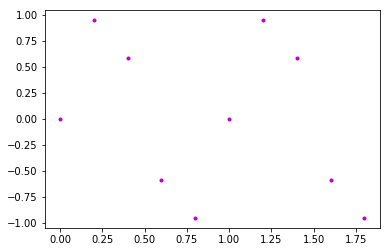

In [4]:
T = 1
n = 1
step = (T / n) * 0.2

x_raw = np.arange(0, 2*T, step, float)
y_raw = np.sin(2 * math.pi * x_raw)

plt.plot(x_raw, y_raw, color='m', linestyle='', marker='.')
plt.show()

### 为数据加上高斯白噪声，均值0，方差0.2

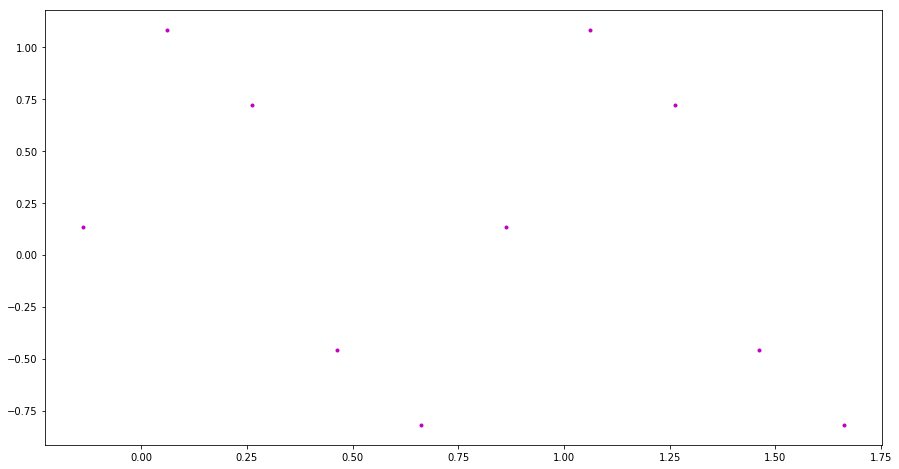

In [11]:
mu = 0
sigma = 0.2

x = x_raw + random.gauss(mu, sigma)
y = y_raw + random.gauss(mu, sigma)

x = np.transpose(np.mat(x))
y = np.transpose(np.mat(y))

# number of example points
m = len(x)

plt.plot(x, y, color='m', linestyle='', marker='.')
plt.show()

### 根据最小二乘法使用1-20阶的多项式拟合数据

![](https://tva1.sinaimg.cn/large/006y8mN6ly1g6yyzo0dxrj309902kmx7.jpg)

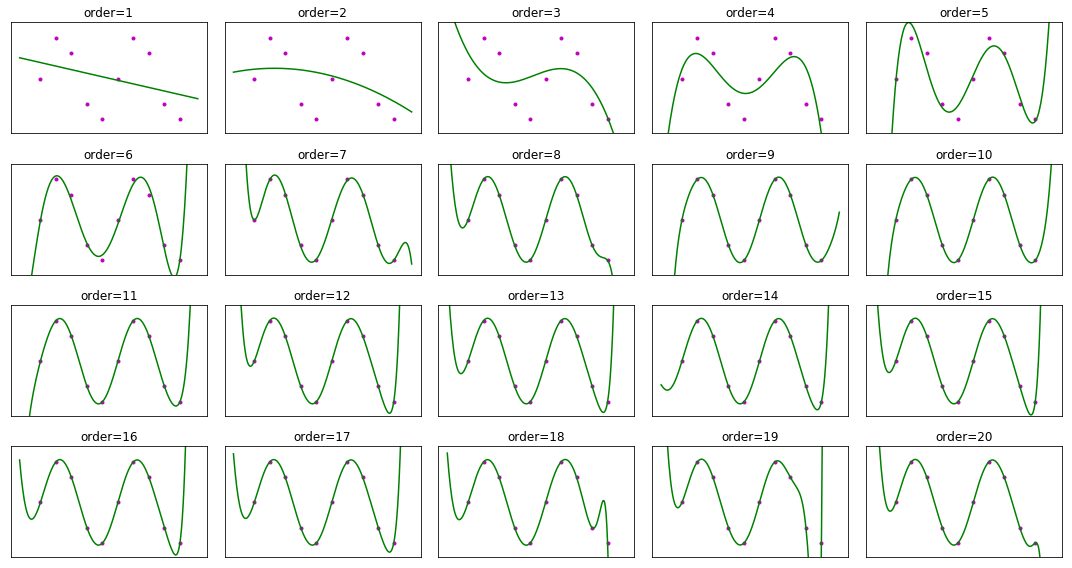

In [6]:
def least_square(x, y, order):
    matrix_left = np.empty([order + 1, order + 1], dtype = float)
    matrix_right = np.empty([order + 1, 1], dtype = float)
    for i in range(0, order + 1):
        row = matrix_left[i]
        for j in range(i, order + 1 + i):
            sum = 0
            for xx in x:
                sum = sum + xx**j
            row[j - i] = sum
    
    for i in range(0, order + 1):
        sum = 0
        j = 0
        for xx in x:
            sum = sum + y[j] * xx**i
            j = j + 1
        matrix_right[i][0] = sum
    
    return np.linalg.solve(matrix_left, matrix_right)

def func_solve(x, a):
    res=0
    for i in range(len(a)):
        res+=a[i]*x**i
    return res

pylab.rcParams['figure.figsize'] = (15.0, 8.0)
for i in range(20):
    ax = plt.subplot(4, 5, 1+i)
    ax.set_title('order=' + str(i+1))
    plt.xticks(())
    plt.yticks(())
    a = least_square(x, y, i+1)
    after_x = np.arange(-0.2, 2*T+0.1, 0.01)
    after_y = func_solve(after_x, a)
    plt.ylim([-1.3, 1.3])
    plt.plot(x, y, color='m', linestyle='', marker='.')
    plt.plot(after_x,after_y,color='g',linestyle='-',marker='')

plt.tight_layout()
plt.show()

### 30阶可观察过拟合情况

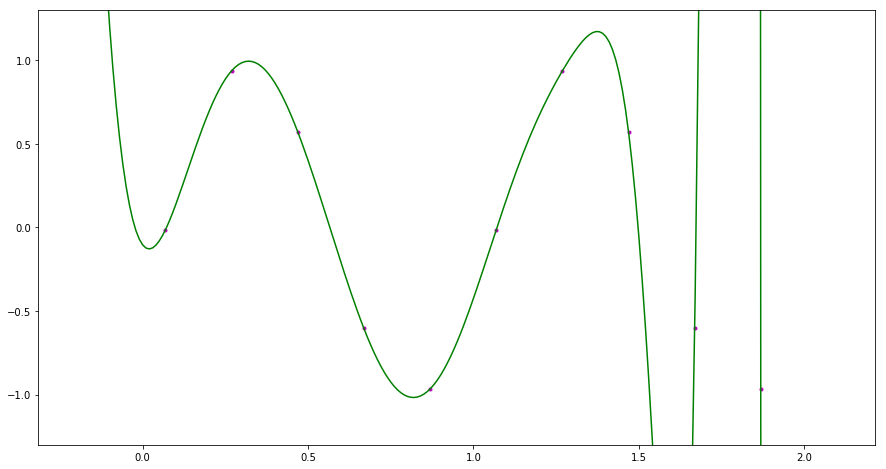

In [7]:
a = least_square(x, y, 30)
after_x = np.arange(-0.2, 2*T+0.1, 0.01)
after_y = func_solve(after_x, a)
plt.ylim([-1.3, 1.3])
plt.plot(x, y, color='m', linestyle='', marker='.')
plt.plot(after_x,after_y,color='g',linestyle='-',marker='')
plt.show()

### 最小二乘法的解析解（无正则项）
![](https://tva1.sinaimg.cn/large/006y8mN6ly1g6yy5zwc4aj304v02i0sm.jpg)

![](https://tva1.sinaimg.cn/large/006y8mN6ly1g6ywn8f1vlj3060027weg.jpg)

In [8]:
# 注意此处的x与y是样本的x和y
def analytical_solution_without_regularizer(x, y, order):
    
    matrix_left = np.zeros((len(x), order+1))
    
    for i in range(len(x)):
        for j in range(order+1):
            if j == 0:
                matrix_left[i][j] = 1
            else:
                matrix_left[i][j] = matrix_left[i][j-1] * x[i][0]
    
    m1 = matrix_left
    m2 = np.transpose(m1)
    
    # 注意此处为广义逆
    return np.dot(np.dot(np.linalg.pinv(np.dot(m2, m1)), m2),  y)

使用解析解拟合16阶多项式

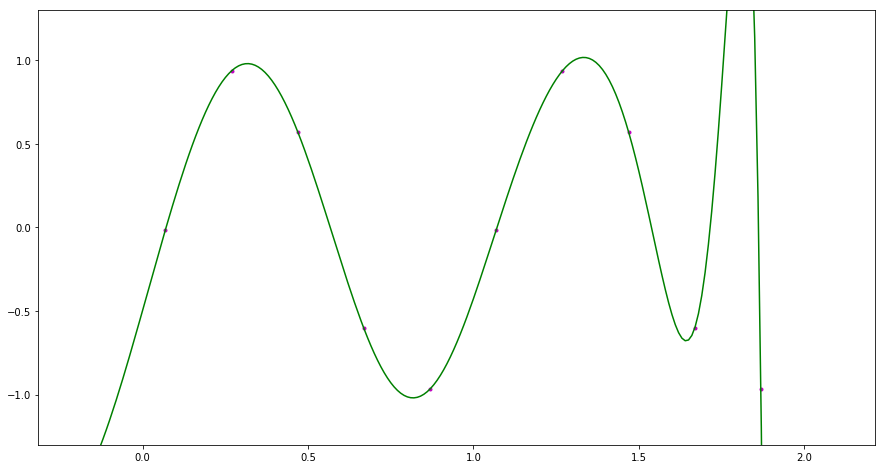

In [9]:
a = analytical_solution_without_regularizer(x, y, 16)

after_x = np.arange(-0.2, 2*T+0.1, 0.01)
after_y = np.transpose(func_solve(after_x, a))
after_x = np.transpose(np.mat(after_x))

plt.ylim([-1.3, 1.3])
plt.plot(x, y, color='m', linestyle='', marker='.')
plt.plot(after_x, after_y, color='g',linestyle='-',marker='')
plt.show()

### 使用有正则项的解析解（过度惩罚可能导致退化）

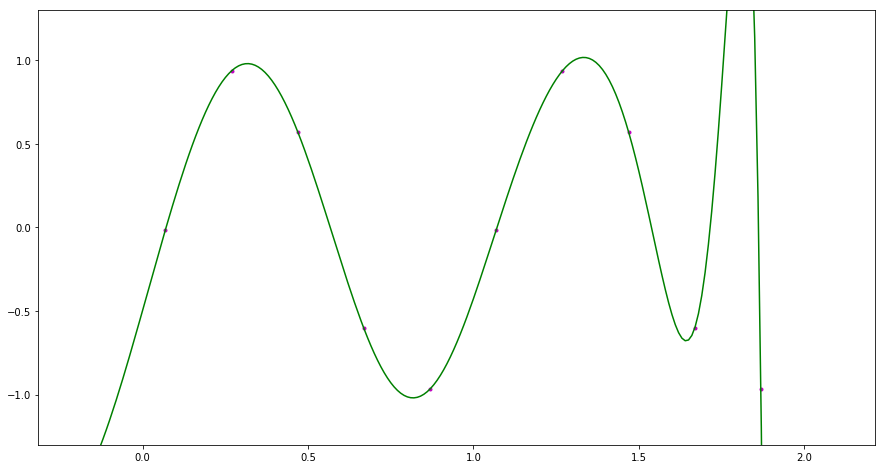

In [10]:
def analytical_solution_with_regularizer(x, y, order, regularizer):
    
    matrix_left = np.ones((len(x), order+1), dtype = float)
    
    for i in range(len(x)):
        for j in range(order+1):
            if j == 0:
                matrix_left[i][j] = 1
            else:
                matrix_left[i][j] = matrix_left[i][j-1] * x[i][0]
    
    m1 = matrix_left
    m2 = np.transpose(m1)
    return np.dot(np.dot(np.linalg.pinv(np.dot(m2, m1)), m2),  y)
    return np.dot(np.dot(np.linalg.pinv(np.dot(m2, m1) + regularizer * np.eye(order+1)), m2),  y)

a = analytical_solution_with_regularizer(x, y, 16, 0.1)

after_x = np.arange(-0.2, 2*T+0.1, 0.01)
after_y = np.transpose(func_solve(after_x, a))
after_x = np.transpose(np.mat(after_x))

plt.ylim([-1.3, 1.3])
plt.plot(x, y, color='m', linestyle='', marker='.')
plt.plot(after_x,after_y,color='g',linestyle='-',marker='')
plt.show()

### 使用梯度下降法拟合函数

定义代价函数（均方误差代价函数）及其梯度为：

![](https://tva1.sinaimg.cn/large/006y8mN6gy1g6z9rt8m3sj30cj02v0ss.jpg)

![](https://tva1.sinaimg.cn/large/006y8mN6gy1g6za6xpl3kj30ec05zjro.jpg)

In [9]:
def loss_function(theta, X, y):
    temp = np.dot(X, theta) - np.transpose(y)
    return (1.0 / (2 * m)) * np.dot(np.transpose(temp), temp)

def gradient_function(theta, X, y):
    temp = np.dot(X, theta) - y
    return (1.0 / m) * np.dot(np.transpose(X), temp) + 0.0001 * theta

梯度下降法

In [10]:
def gradient_decent(theta, alpha, X, y):
    # theta为初始位置（列向量）
    gradient = gradient_function(theta, X, y)
    while not np.all(np.absolute(gradient) <= 1e-3):
        theta = theta - alpha * gradient
        gradient = gradient_function(theta, X, y)
    return theta

使用梯度下降法拟合四阶多项式

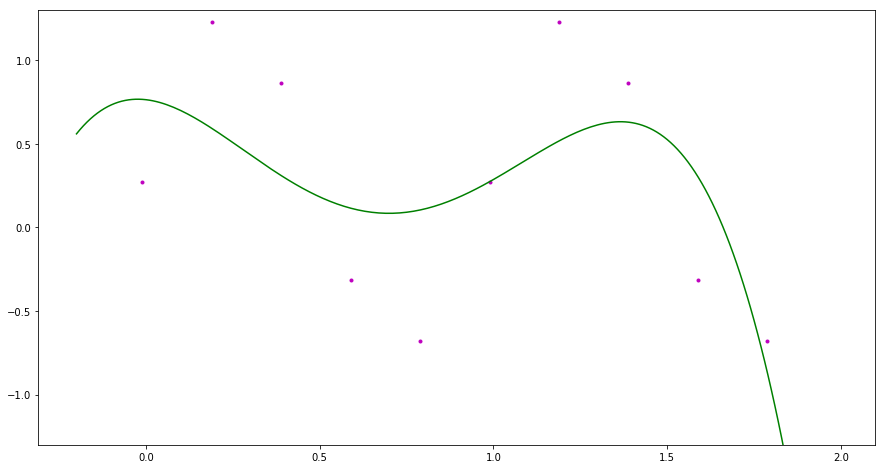

In [11]:
order = 4

theta = np.ones((order + 1, 1))
alpha = 0.01

X = np.zeros((m, order + 1))
for i in range(m):
    for j in range(order + 1):
        if j == 0:
            X[i][j] = 1
        else:
            X[i][j] = X[i][j-1] * x[i]
            
res = gradient_decent(theta, alpha, X, y)

after_x = np.arange(-0.2, 2*T, 0.01)
after_y = np.transpose(func_solve(after_x, res))
after_x = np.transpose(np.mat(after_x))

plt.ylim([-1.3, 1.3])
plt.plot(np.transpose(x), np.transpose(y), color='m', linestyle='', marker='.')
plt.plot(after_x,after_y,color='g',linestyle='-',marker='')
plt.show()

### 共轭梯度法

函数形式$Ax=b$

![](https://tva1.sinaimg.cn/large/006y8mN6gy1g72gmseqvwj30c80akmxw.jpg)

In [ ]:
def conjugate_gradient(A, b, order):
    # b: m, 1
    # A: m, order+1
    # res: m, 1
    # r: m, 1
    # p: m, 1
    res = np.ones((order+1, 1))
    r = b - np.dot(A, res)
    p = r
    k = 0
    while True:
        alpha = np.dot(np.transpose(r), r) / np.dot(np.dot(np.transpose(p), A), p)
        res = res + np.array(alpha)[0][0] * p
        r1 = r - np.array(alpha)[0][0] * np.dot(A, p)
        if (np.all(np.absolute(r1) < 1e-5)):
            return res
        beta = np.dot(np.transpose(r1), r1) / np.dot(np.transpose(r), r)
        p = -r1 + np.array(beta)[0][0] * p
        r = r1
        k = k+1
        if k%2000 == 0:
            print(r1)

# 注意需要保证A是对称正定，即order+1 = m
order = 9

X = np.zeros((m, order + 1))
for i in range(m):
    for j in range(order + 1):
        if j == 0:
            X[i][j] = 1
        else:
            X[i][j] = X[i][j-1] * x[i]

res = conjugate_gradient(X, y, order)

after_x = np.arange(-0.2, 2*T, 0.01)
after_y = np.transpose(func_solve(after_x, res))
after_x = np.transpose(np.mat(after_x))

plt.ylim([-1.3, 1.3])
plt.plot(np.transpose(x), np.transpose(y), color='m', linestyle='', marker='.')
plt.plot(after_x,after_y,color='g',linestyle='-',marker='')
plt.show()

In [48]:
def conjugate_gradient1(A, b, order):
    res = np.ones((order+1, 1))
    d = np.zeros((m, 1))
    r = -b
    k = 0
    while True:
        denom1 = np.array(np.dot(np.transpose(r), r))[0][0]
        r = np.dot(A, res) - b
        num1 = np.array(np.dot(np.transpose(r), r))[0][0]
        if num1 < 1e-5:
            return res
        d = -r + num1 / denom1 * d
        
        num2 = np.array(np.dot(np.transpose(d), r))[0][0]
        denom2 = np.array(np.dot(np.dot(np.transpose(d), A), d))[0][0]
        a = -num2 / denom2
        res = res + a * d
        k = k + 1
        if k % 10000 == 0:
            print(num1)

# 注意需要保证A是对称正定，即order+1 = m
order = 9

X = np.zeros((m, order + 1))
for i in range(m):
    for j in range(order + 1):
        if j == 0:
            X[i][j] = 1
        else:
            X[i][j] = X[i][j-1] * x[i]

res = conjugate_gradient1(X, y, order)

after_x = np.arange(-0.2, 2*T, 0.01)
after_y = np.transpose(func_solve(after_x, res))
after_x = np.transpose(np.mat(after_x))

plt.ylim([-1.3, 1.3])
plt.plot(np.transpose(x), np.transpose(y), color='m', linestyle='', marker='.')
plt.plot(after_x,after_y,color='g',linestyle='-',marker='')
plt.show()

[[-0.13815937]
 [ 0.06184063]
 [ 0.26184063]
 [ 0.46184063]
 [ 0.66184063]
 [ 0.86184063]
 [ 1.06184063]
 [ 1.26184063]
 [ 1.46184063]
 [ 1.66184063]]
[[ 1.00000000e+00 -1.38159372e-01  1.90880121e-02 -2.63718777e-03
   3.64352206e-04 -5.03386720e-05  6.95475932e-06 -9.60865181e-07
   1.32752530e-07 -1.83410062e-08]
 [ 1.00000000e+00  6.18406279e-02  3.82426326e-03  2.36494841e-04
   1.46249895e-05  9.04418531e-07  5.59298098e-08  3.45873456e-09
   2.13890317e-10  1.32271115e-11]
 [ 1.00000000e+00  2.61840628e-01  6.85605144e-02  1.79519281e-02
   4.70054414e-03  1.23079343e-03  3.22271724e-04  8.43838306e-05
   2.20951152e-05  5.78539883e-06]
 [ 1.00000000e+00  4.61840628e-01  2.13296766e-01  9.85091121e-02
   4.54955102e-02  2.10116750e-02  9.70404517e-03  4.48172232e-03
   2.06984145e-03  9.55936874e-04]
 [ 1.00000000e+00  6.61840628e-01  4.38033017e-01  2.89908047e-01
   1.91872924e-01  1.26989296e-01  8.40466756e-02  5.56255046e-02
   3.68152189e-02  2.43658076e-02]
 [ 1.00000000e

KeyboardInterrupt: 